# Smoothing particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_smoothing as plt_sp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import smoothing_particles as sp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

ordering = True
video_name = "3n_1m_2f_240213_1"
n_particles = int(video_name[0])
save_figures = True
x_bounds = [0, 1080]
y_bounds = [50, 1860]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Load tracked data

In [3]:
df_tracked = pd.read_csv("{}/clustered_{}.csv".format(output_path, video_name), low_memory=False)
df_tracked.head(n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,1395.714555,74.415535,1394.490291,76.110912,0.0,1361.000000,31.000000,0.541176,1431.000000,63.000000,1.444069,13260.0,258.805432,90.401761,0.937009,3,NaN,NaN,NaN,NaN,False,False,False
1,1,0,936.520344,150.086347,938.328113,150.661421,0.0,883.000000,82.000000,0.596078,867.000000,84.000000,1.091933,15484.0,233.558569,101.816993,0.899977,3,NaN,NaN,NaN,NaN,False,False,False
2,2,0,1251.335731,953.094922,1250.768461,953.328558,NaN,1251.335731,953.094922,NaN,1251.335731,953.094922,-1.091933,16403.0,291.441219,105.274607,0.932480,3,NaN,NaN,NaN,NaN,False,False,False


In [4]:
df_tracked.tail(n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
69312,0,69318,1216.992000,645.641217,1214.784347,644.239637,NaN,1216.992000,645.641217,NaN,1216.992000,645.641217,0.103019,17250.0,287.704498,95.392289,0.943433,3,3.0,0.000000,0.000000,0.0,False,False,False
69313,1,69318,1611.786366,946.720849,1607.427576,949.525335,NaN,1635.981872,911.167895,NaN,1577.685643,968.674579,-1.006767,16165.0,279.351236,112.865411,0.914747,3,3.0,0.230870,-0.239041,0.0,False,False,False
69314,2,69318,127.032906,960.811019,136.169454,964.182802,NaN,127.032906,960.811019,NaN,127.032906,960.811019,1.072786,13176.0,257.117665,93.836866,0.931024,3,3.0,-0.012984,0.045038,0.0,False,False,False


## Swapping mixed IDs

In [5]:
omega_threshold = 20 * np.pi / 180  # Angular velocity per frame (in degrees)
velocity_threshold = 83  # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
delta = 400

from importlib import reload
reload(sp)

arg_list = [
    # VIDEO 1
    [0    , 10000, velocity_threshold, omega_threshold, True],
    [10000, 20000, velocity_threshold, omega_threshold, True],
    [20000, 30000, velocity_threshold, omega_threshold, True],
    [30000, 40000, velocity_threshold, omega_threshold, True],
    [40000, 50000, velocity_threshold, omega_threshold, True],
    [50000, 60000, velocity_threshold, omega_threshold, True],
    [60000, 69319, velocity_threshold, omega_threshold, True]#,
    # [70000, 80000, velocity_threshold, omega_threshold, True],
    # [80000, 90000, velocity_threshold, omega_threshold, True],
    # [90000, 100000, velocity_threshold, omega_threshold, True],
    # [100000, 108000, velocity_threshold, omega_threshold, True]
]

df_final = sp.smooth_frames(
    df_tracked=df_tracked,
    arg_list=arg_list,
    order=False,
    log_path=log_path,
    log_filename="log_{}".format(video_name),
    verbose=1,
    tqdm_bar=True
)

df_final.head(8)

Thresholds:
	- Velocity: 83 
	- Angle: 20.0 



100%|█████████████████████████| 7/7 [00:30<00:00,  4.35s/it]


Time: 30000 Chunks 2 Allowed time 30000 Permutation [0 1 2]
Time: 60000 Chunks 2 Allowed time 60000 Permutation [0 1 2]


,allowed_frame,time,smooth_chunk,id,permuted_id,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,corrected_orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,True,0,chunk_00000_10000,0,0,1395.714555,74.415535,1394.490291,76.110912,0.0,1361.000000,31.000000,0.541176,1431.000000,63.000000,1.444069,1.444069,13260.0,258.805432,90.401761,0.937009,3,NaN,NaN,NaN,NaN,False,False,False
1,True,0,chunk_00000_10000,1,1,936.520344,150.086347,938.328113,150.661421,0.0,883.000000,82.000000,0.596078,867.000000,84.000000,1.091933,1.091933,15484.0,233.558569,101.816993,0.899977,3,NaN,NaN,NaN,NaN,False,False,False
2,True,0,chunk_00000_10000,2,2,1251.335731,953.094922,1250.768461,953.328558,NaN,1251.335731,953.094922,NaN,1251.335731,953.094922,-1.091933,-1.091933,16403.0,291.441219,105.274607,0.932480,3,NaN,NaN,NaN,NaN,False,False,False
3,True,3,chunk_00000_10000,0,0,1395.656076,74.537838,1394.472187,76.286303,0.0,1360.000000,31.000000,0.541176,1413.000000,63.000000,1.443184,1.443184,13439.0,258.831131,90.376534,0.937059,3,3.0,-0.019493,0.040767,-0.000295,False,False,False
4,True,3,chunk_00000_10000,1,1,936.681533,150.166346,938.579758,150.730723,0.0,883.000000,82.000000,0.600000,886.000000,88.000000,1.091387,1.091387,15606.0,233.428291,102.098531,0.899273,3,3.0,0.053730,0.026666,-0.000182,False,False,False
5,True,3,chunk_00000_10000,2,2,1259.734230,945.028132,1260.310406,945.472877,0.0,1269.000000,888.000000,0.588235,1363.000000,911.000000,-1.545628,-1.545628,16138.0,293.031723,108.012501,0.929587,3,3.0,2.799499,-2.688930,-0.151232,False,False,False
6,True,6,chunk_00000_10000,0,0,1395.666146,74.585565,1394.489867,76.351090,0.0,1360.000000,31.000000,0.541176,1421.000000,63.000000,1.443277,1.443277,13440.0,258.874172,90.337592,0.937136,3,3.0,0.003357,0.015909,0.000031,False,False,False
7,True,6,chunk_00000_10000,1,1,936.829250,150.266330,938.833805,150.875648,0.0,883.000000,82.000000,0.600000,886.000000,88.000000,1.091475,1.091475,15631.0,234.114523,102.033044,0.900031,3,3.0,0.049239,0.033328,0.000029,False,False,False


In [7]:
df_final.tail(5)

,allowed_frame,time,smooth_chunk,id,permuted_id,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,corrected_orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
69310,True,69315,chunk_60000_69319,1,1,1611.093755,947.437972,1606.599454,950.315107,NaN,1659.484767,876.332065,NaN,1542.892309,991.345434,-1.006767,-1.006767,16165.0,279.351236,112.865411,0.914747,3,3.0,-0.046434,0.044532,0.0,False,False,False
69311,True,69315,chunk_60000_69319,2,2,127.071858,960.675905,136.097853,964.075332,NaN,127.071858,960.675905,NaN,127.071858,960.675905,1.072786,-1.072786,13176.0,257.117665,93.836866,0.931024,3,3.0,0.080969,-0.075207,0.0,False,False,False
69312,True,69318,chunk_60000_69319,0,0,1216.992000,645.641217,1214.784347,644.239637,NaN,1216.992000,645.641217,NaN,1216.992000,645.641217,0.103019,0.103019,17250.0,287.704498,95.392289,0.943433,3,3.0,0.000000,0.000000,0.0,False,False,False
69313,True,69318,chunk_60000_69319,1,1,1611.786366,946.720849,1607.427576,949.525335,NaN,1635.981872,911.167895,NaN,1577.685643,968.674579,-1.006767,-1.006767,16165.0,279.351236,112.865411,0.914747,3,3.0,0.230870,-0.239041,0.0,False,False,False
69314,True,69318,chunk_60000_69319,2,2,127.032906,960.811019,136.169454,964.182802,NaN,127.032906,960.811019,NaN,127.032906,960.811019,1.072786,-1.072786,13176.0,257.117665,93.836866,0.931024,3,3.0,-0.012984,0.045038,0.0,False,False,False


## Interpolation over not allowed frames

In [8]:
if ordering:
    df_full = df_final.copy().sort_values(["time", "permuted_id"])
    for id_ in range(len(df_full["permuted_id"].unique())):
        mask = df_full.loc[:,"permuted_id"]==df_full["permuted_id"].unique()[id_]
        df_full[mask]=df_full[mask].interpolate(method="linear")

In [9]:
if ordering:
    cols = [
        "id", "permuted_id", "time", "position_x", "position_y", "weighted_x", "weighted_y",
        "darkest_v", "darkest_x", "darkest_y", "lightest_v", "lightest_x", "lightest_y",
        "orientation", "corrected_orientation", "area", "axis_major", "axis_minor", "eccentricity"
    ]
    df_temp = df_full[cols]
    df_temp.to_csv("{}/interpolated_{}.csv".format(output_path, video_name), index=False)
    df_temp

Thresholds:
	- Velocity: 31.200928981799805 
	- Angle: 4.880595819940755 



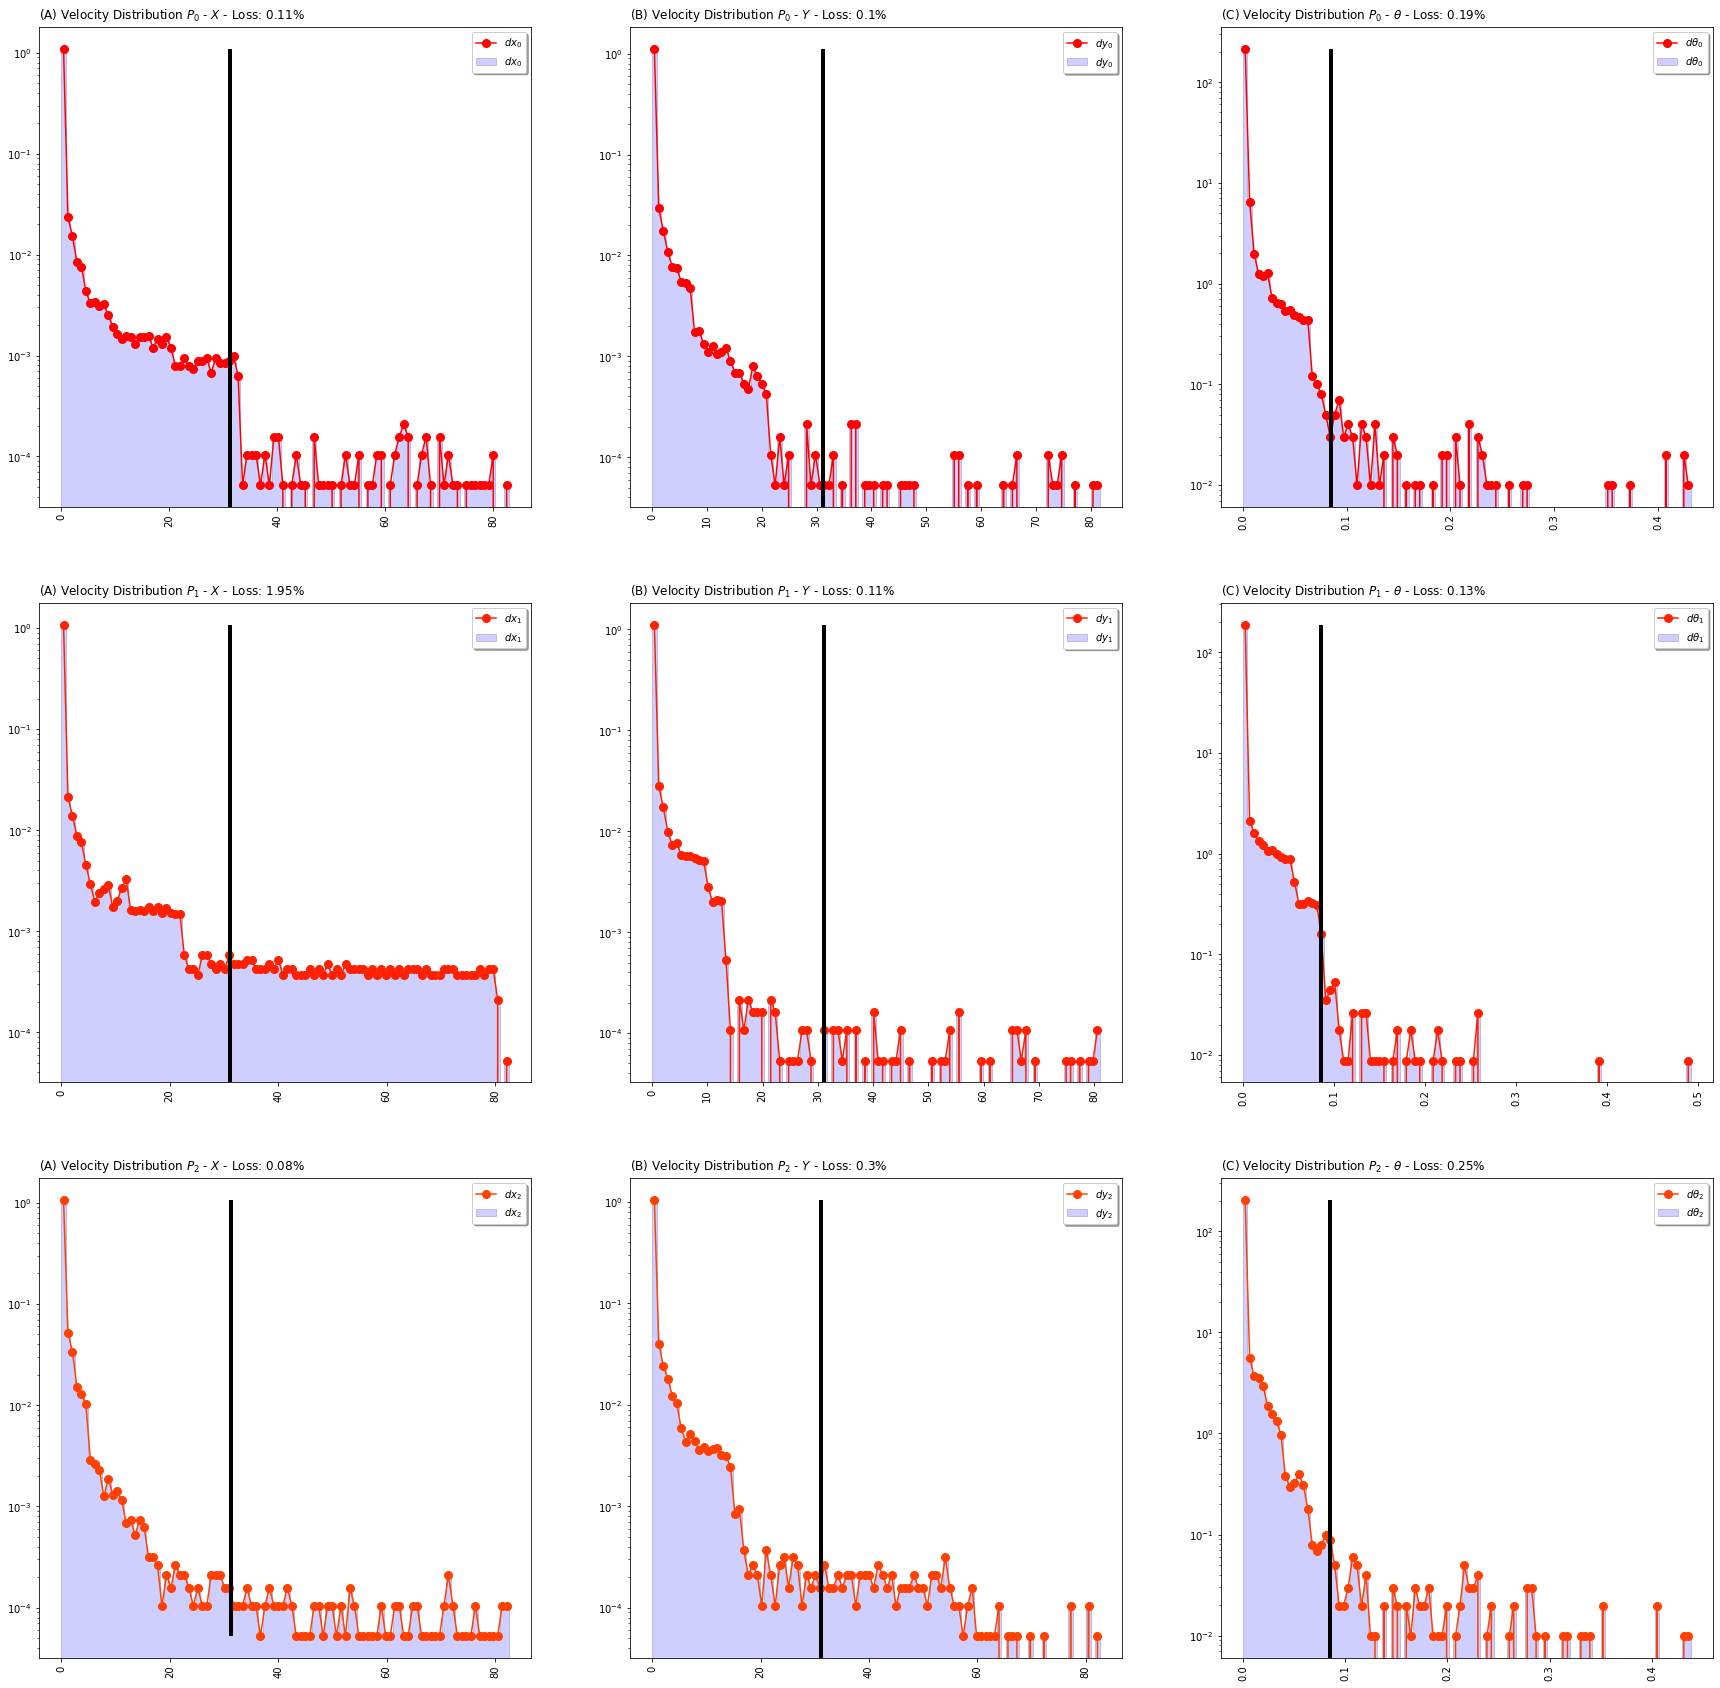

In [10]:
if ordering:
    bins = 100
    width = 10
    fancy_legend = True
    omega_threshold = df_full["velocity_orientation"].abs().quantile(0.9965) # Angular velocity per frame
    velocity_threshold = df_full["velocity_x"].abs().quantile(0.9901) # Velocity per frame limited with half average size of particle
    print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    df_smooth["orientation"] = df_smooth["corrected_orientation"]
    plt_cp.plot_velocities_distribution(
        df_tracked=df_smooth,
        bins=bins,
        velocity_threshold=velocity_threshold,
        omega_threshold=omega_threshold,
        width=width,
        fancy_legend=fancy_legend
    )

Original


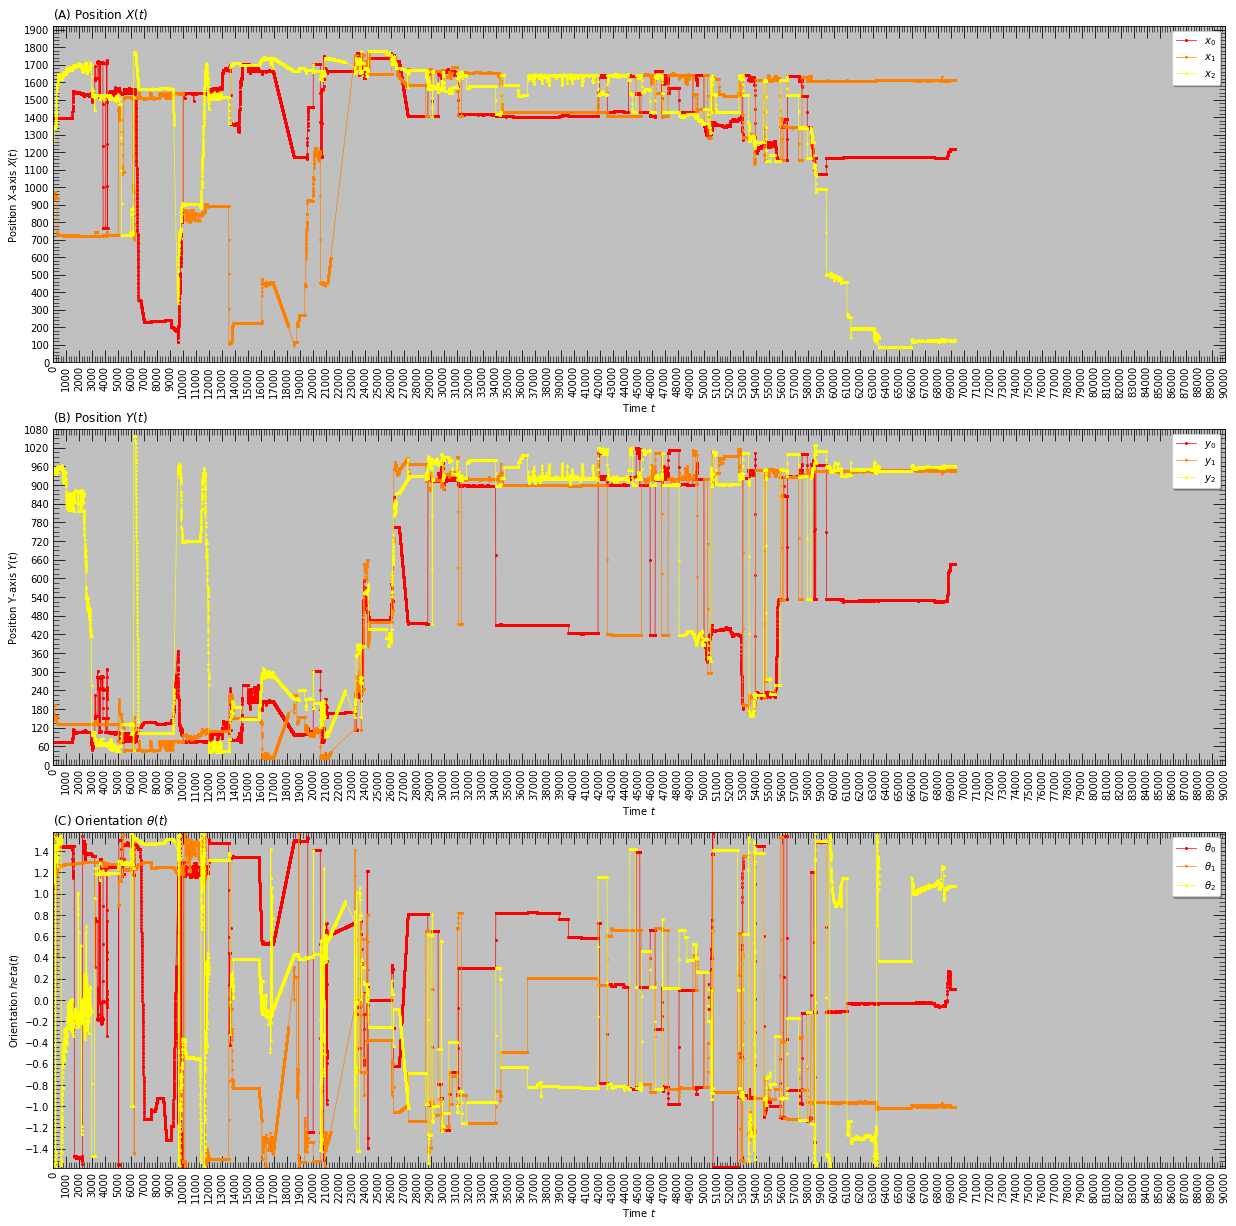

Corrected Orientation


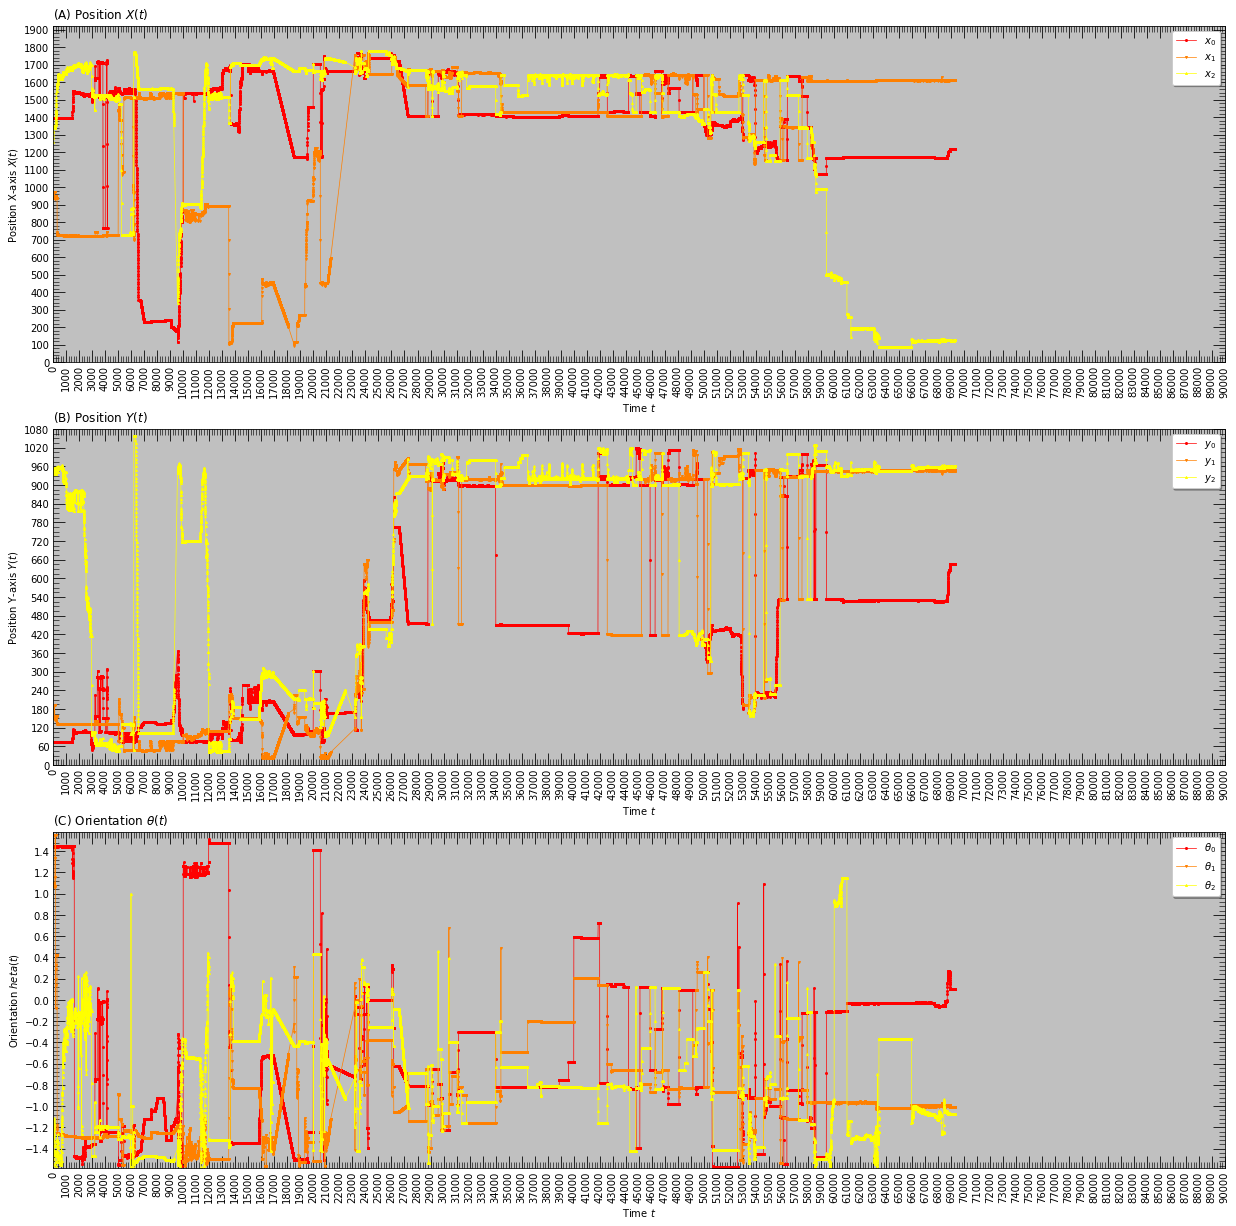

In [11]:
if ordering:
    width = 21
    n_x_breaks = 100
    n_y_breaks = 20
    t0, tf   = 0, 90000  # 22200, 24300
    t0_, tf_ = 0, 90000  # 22200, 24300
    t_bounds = [t0_, tf_]
    p_bounds = [[0, 1920], [0, 1080], [-1.58, 1.58]]
    fancy_legend = True

    print("Original")
    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    velocity_threshold = df_full["velocity_x"].abs().quantile(0.9701) # Velocity per frame limited with half average size of particle
    plt_sp.plot_tracking_evolution(
        df_smooth=df_smooth[((df_smooth["velocity_x"] <= velocity_threshold) & (df_smooth["velocity_y"] <= velocity_threshold))],
        width=width,
        n_x_breaks=n_x_breaks,
        n_y_breaks=n_y_breaks,
        t_bounds=[t0, tf],
        p_bounds=p_bounds,
        fancy_legend=fancy_legend
    )

    print("Corrected Orientation")
    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    df_smooth["orientation"] = df_smooth["corrected_orientation"]
    plt_sp.plot_tracking_evolution(
        df_smooth=df_smooth[((df_smooth["velocity_x"] <= velocity_threshold) & (df_smooth["velocity_y"] <= velocity_threshold))],
        width=width,
        n_x_breaks=n_x_breaks,
        n_y_breaks=n_y_breaks,
        t_bounds=[t0, tf],
        p_bounds=p_bounds,
        fancy_legend=fancy_legend
    )

## Setting video information

In [ ]:
# # Load the video
# reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# # Check the number of frames
# num_frames = reader.count_frames()
# print("Total frames: {}".format(num_frames))

# # Extract a frame to inspect the content
# time = 0
# frame = reader.get_data(time)
# print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

## Comparative of process

In [ ]:
# # Original frame
# time = 209  #271  # 209  # 80
# times = [time - 1, time, time + 1]
# reinforce_boundaries = True
# remove_holes = False
# type = "local equalized"
# clip_limit = 0.05
# threshold = 0.19
# sigma = 1.5
# x_bounds = x_bounds  # [40, 1020]
# y_bounds = y_bounds  # [160, 1740]
# region_area_min = 200
# axis_major_min = 94
# eccentricity_max = 0.99


# df_tracked_frame_0 = tp.process_frame(
#     reinforce_boundaries=reinforce_boundaries,
#     remove_holes=remove_holes,
#     type=type,
#     clip_limit=clip_limit,
#     threshold=threshold,
#     sigma=sigma,
#     x_bounds=x_bounds,
#     y_bounds=y_bounds,
#     region_area_min=region_area_min,
#     axis_major_min=axis_major_min,
#     eccentricity_max=eccentricity_max,
#     tracking_list=[times[0], reader.get_data(times[0])]
# )

# df_tracked_frame_1 = tp.process_frame(
#     reinforce_boundaries=reinforce_boundaries,
#     remove_holes=remove_holes,
#     type=type,
#     clip_limit=clip_limit,
#     threshold=threshold,
#     sigma=sigma,
#     x_bounds=x_bounds,
#     y_bounds=y_bounds,
#     region_area_min=region_area_min,
#     axis_major_min=axis_major_min,
#     eccentricity_max=eccentricity_max,
#     tracking_list=[times[1], reader.get_data(times[1])]
# )

# df_tracked_frame_2 = tp.process_frame(
#     reinforce_boundaries=reinforce_boundaries,
#     remove_holes=remove_holes,
#     type=type,
#     clip_limit=clip_limit,
#     threshold=threshold,
#     sigma=sigma,
#     x_bounds=x_bounds,
#     y_bounds=y_bounds,
#     region_area_min=region_area_min,
#     axis_major_min=axis_major_min,
#     eccentricity_max=eccentricity_max,
#     tracking_list=[times[2], reader.get_data(times[2])]
# )

# df_tracked_old = pd.concat([df_tracked_frame_0, df_tracked_frame_1, df_tracked_frame_2], ignore_index=True)

# width = 10
# n_x_breaks = 20
# n_y_breaks = 20
# fancy_legend = True
# x_legend = 1.001
# y_legend = 0.891

# df_smooth = df_full.copy()
# df_smooth["id"] = df_smooth["permuted_id"]
# df_smooth["orientation"] = df_smooth["corrected_orientation"]

# fig = plt_sp.plot_all_process_frame(
#     reader=reader,
#     times=times,
#     df_tracked=df_tracked_old,
#     df_clustered=df_tracked,
#     df_smoothed=df_smooth,
#     width=width,
#     n_x_breaks=n_x_breaks,
#     n_y_breaks=n_y_breaks,
#     x_bounds=x_bounds,
#     y_bounds=y_bounds,
#     fancy_legend=fancy_legend,
#     x_legend=x_legend,
#     y_legend=y_legend
# )